# Notebook to test edits for visualse_glider.py file

THIS IS ONLY FOR TESTING CODE.  For operational use, start with **visualise_glider.py**

Script to grid glider (slocum) data and make various calculations on the profiles.

1. Works locally on the processed netcdf glider time series *o2.nc
2. Grid glider data
3. Calculate MLD

Runs offline, using the netcdf files created in process_glider_tseries.py

In [1]:

%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
import datetime
from setdir import *
from plotglider_grid import *
from plotglider_tseries import *
from niceplotting import *
from scipy.io import loadmat # to load bathymetry
import xarray as xr
#import seaborn as sns
import glob
from scipy import stats
import cmocean


In [3]:
# Load latest full dataset and gridded profiles

glider_names = {
    'unit_409': 'Grease',
    'unit_398': 'Churchill',
}
unit_list = [(k) for k in glider_names.keys()]

for uname in unit_list:
    # Glider data
    fname = uname+'*_data_o2.nc'

    # Extract a list with the names of existing raw data files
    existing_files = glob.glob(cat_interim_path(fname))

    # Check whether there are any
    if len(existing_files) > 0:
        # Extract the end date from the filename
        existing_files = sorted(existing_files)
        latest_file = existing_files[-1]
        # Open the dataset
        data_ds = xr.open_dataset(latest_file)
        
        if uname=='unit_409':
            exec('unit409=data_ds.copy()')
        elif uname=='unit_398':
            exec('unit398=data_ds.copy()')
        
    #Glider positions
    fname = uname+'_position_2022*nc'

    # Extract a list with the names of existing raw data files
    existing_files = glob.glob(cat_raw_path(fname))

    if len(existing_files) >0:
        existing_files = sorted(existing_files)
        latest_file = existing_files[-1]
        
        pos_ds = xr.open_dataset(latest_file)
        
        if uname=='unit_409':
            exec('unit409pos=pos_ds.copy()')
        elif uname=='unit_398':
            exec('unit398pos=pos_ds.copy()')
            
    # Gridded glider data
    fname = uname+'*_bin10m.nc'
    
    # Extract a list with the names of existing interim data files
    existing_files = glob.glob(cat_proc_path(fname))
    
    # Check whether there are any files
    if len(existing_files) > 0:
        # Extract the most recent filename
        existing_files = sorted(existing_files)
        latest_file = existing_files[-1]
        
    grid_ds = xr.open_dataset(latest_file)
    
    if uname=='unit_409':
        exec('grid409=grid_ds.copy()')
    elif uname=='unit_398':
        exec('grid398=grid_ds.copy()')
        
            
# Location for bathymetry file
matlab_file = 'labsea_66.44W_45.68N_5min.mat'
input_bathy_file = cat_proc_path(matlab_file)
mat_data = loadmat(input_bathy_file)
bathy_data = mat_data['bathy']
bathylat = bathy_data['lat'][0][0].flatten()
bathylon = bathy_data['lon'][0][0].flatten()
bathy = bathy_data['depth'][0][0]




In [4]:
# Initialise the figure directory
figdir = create_figdir()

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

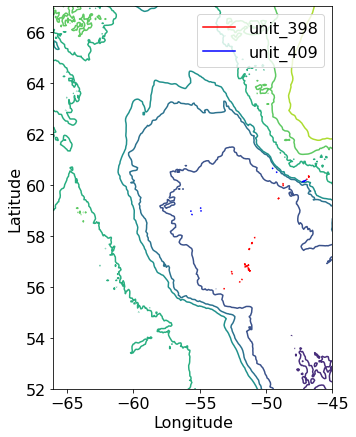

In [5]:
# Map the bathymetry and glider tracks 
# Ok, the glider tracks are spotty: Might mean that the m_gps_lon and m_gps_lat aren't the right variables to download!
map_tracks(bathylon,bathylat,bathy,unit409,unit398)

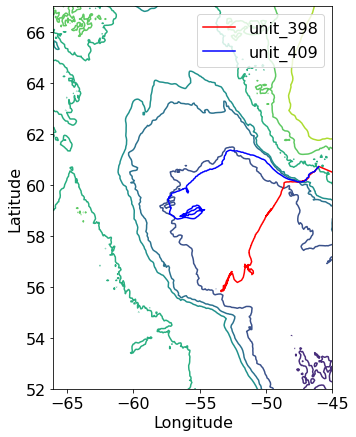

In [6]:
# Map the bathymetry and glider tracks 
# using position data (better)
map_tracks_pos(bathylon,bathylat,bathy,unit409pos,unit398pos)

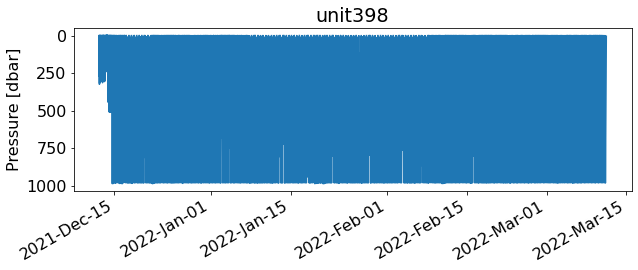

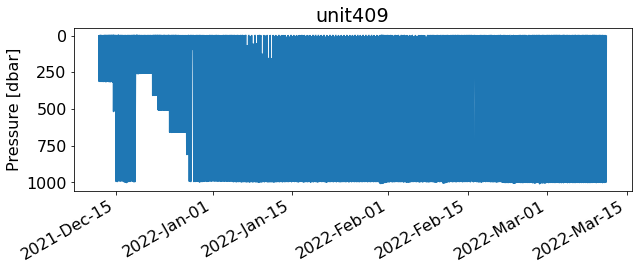

In [7]:
# Plot pressure against time
plot_pressure(unit398,'unit398')
plot_pressure(unit409,'unit409')
# Looks like we are missing recent data from unit398

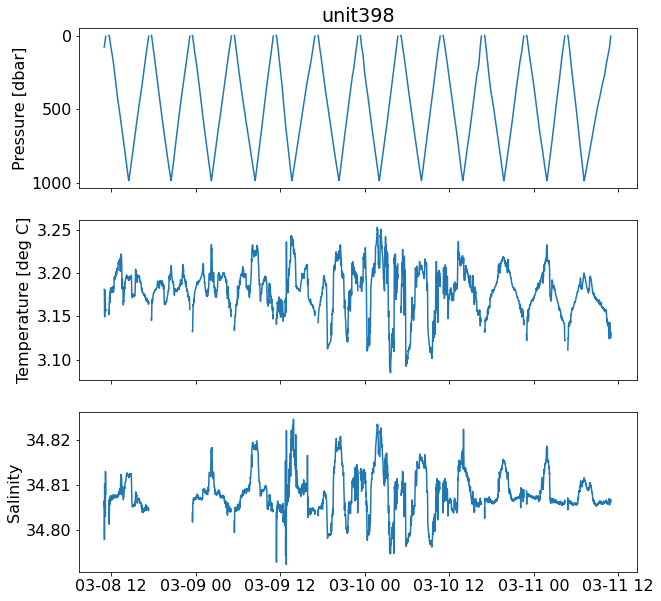

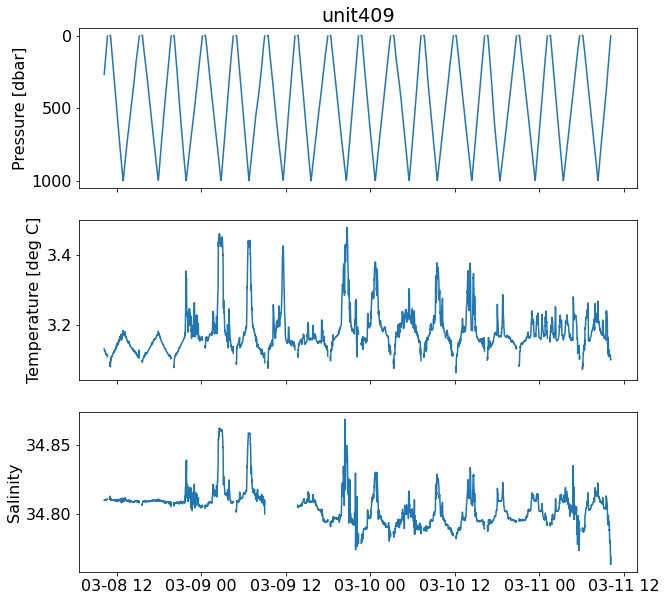

In [8]:
# Plot most recent 3 days
plot_tseries(unit398,3,'unit398')
plot_tseries(unit409,3,'unit409')


# Simple color sections

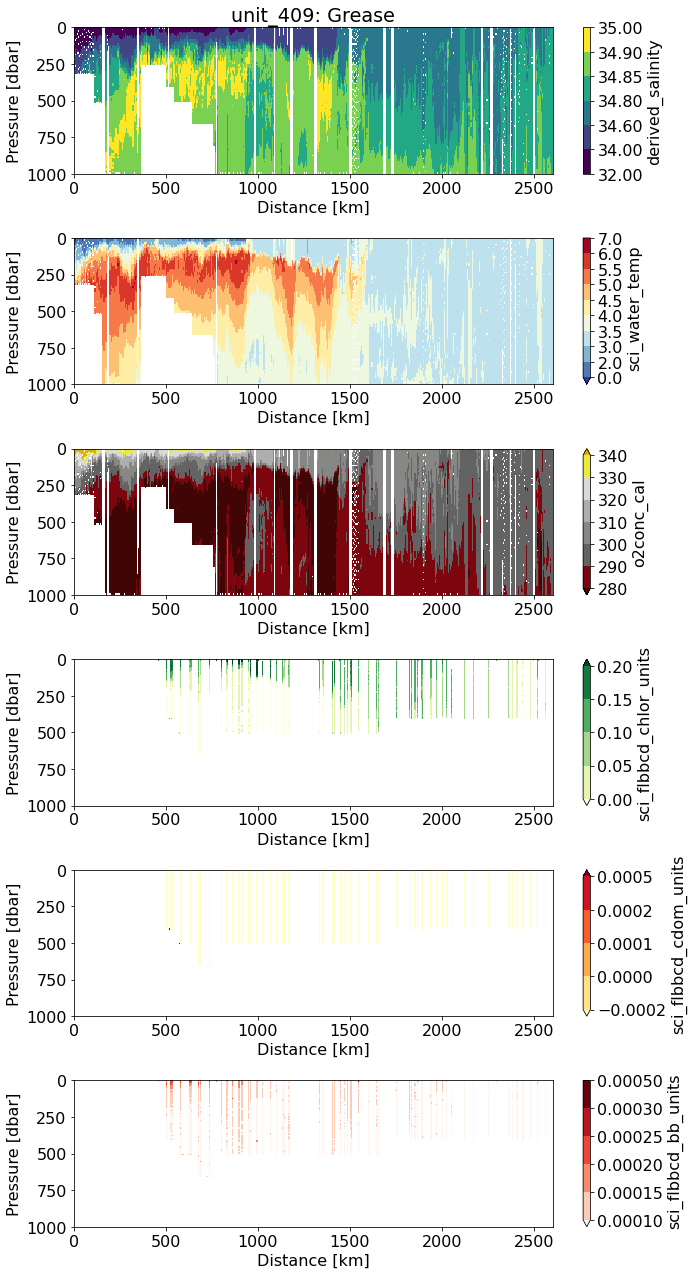

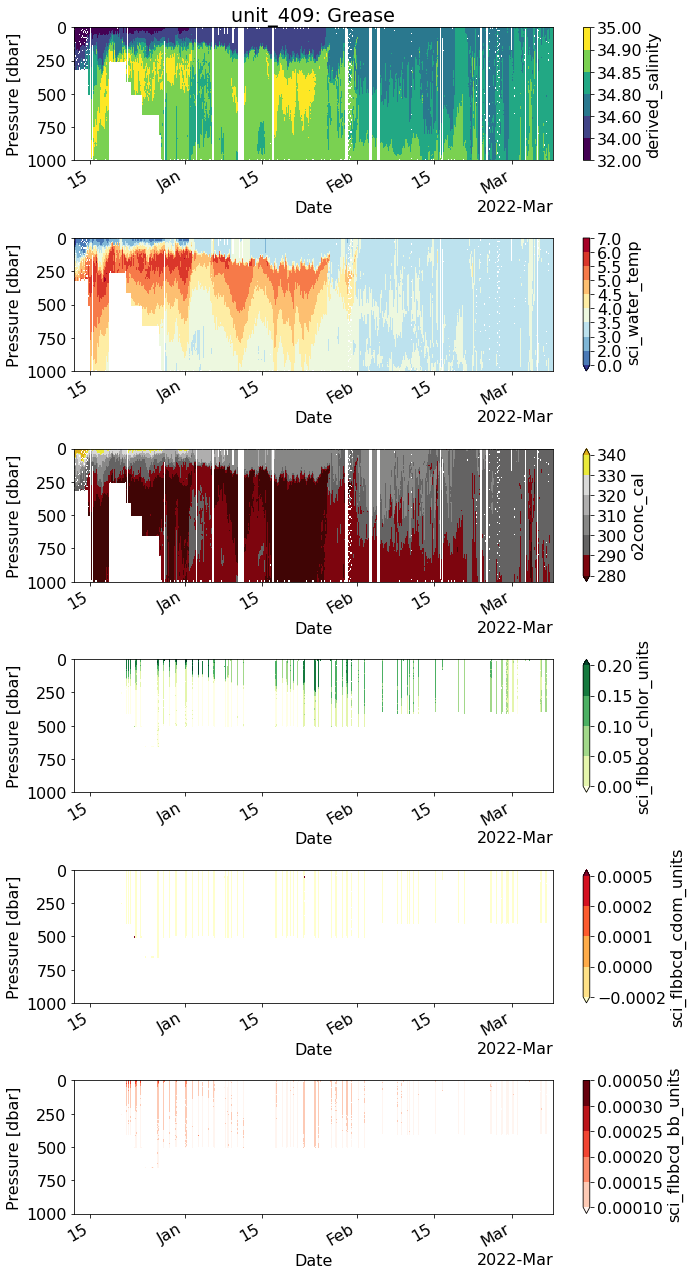

In [10]:
varlist = ['derived_salinity', 'sci_water_temp', 'sci_oxy4_oxygen',
           'sci_flbbcd_chlor_units', 'sci_flbbcd_cdom_units', 
           'sci_flbbcd_bb_units'
          ]
varlist2 = ['derived_salinity', 'sci_water_temp', 'o2conc_cal',
            'sci_flbbcd_chlor_units', 'sci_flbbcd_cdom_units', 
           'sci_flbbcd_bb_units'
            ]
xcoord = 'dist_along_track' # could also be divenum or timevec
plot_sxn(grid409, varlist2,'dist_along_track')
plot_sxn(grid409, varlist2,'timevec')

## ISSUE: Need to add a time axes below the divenumber axis.
## ISSUE: Need better plotting of the gappy wetlabs data

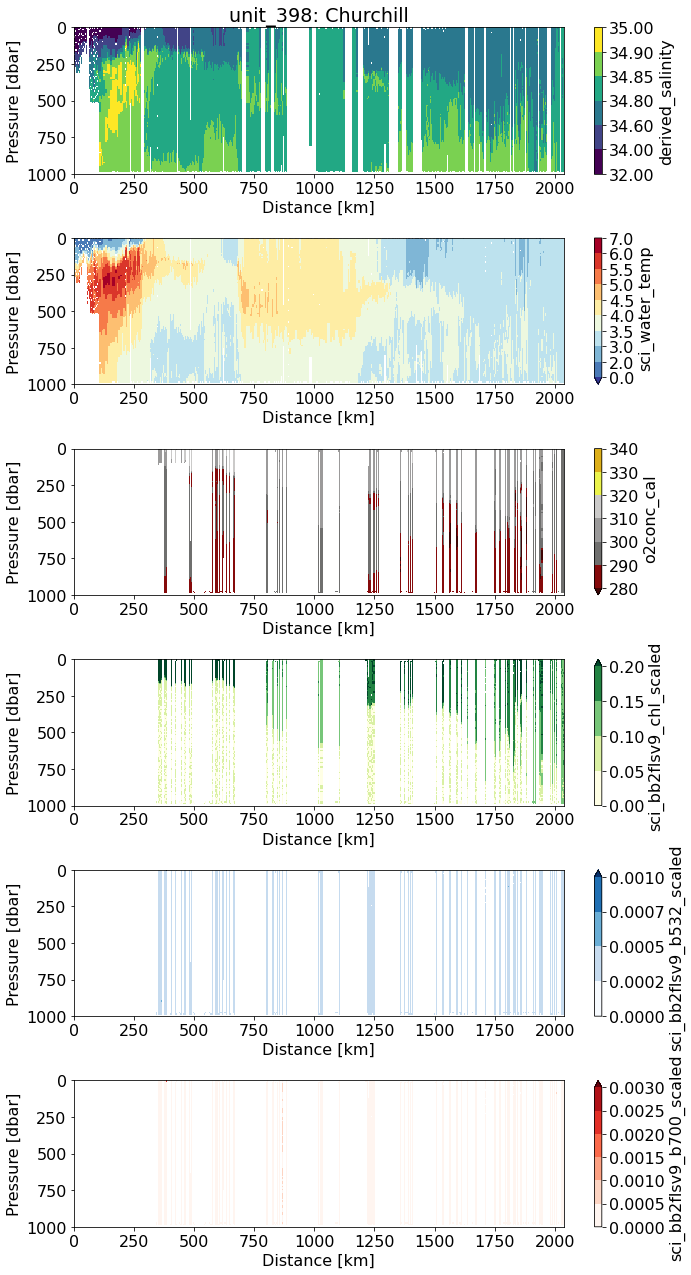

In [12]:
varlist = ['derived_salinity', 'sci_water_temp', 'sci_oxy4_oxygen',
           'sci_bb2flsv9_chl_scaled', 'sci_bb2flsv9_b532_scaled', 
           'sci_bb2flsv9_b700_scaled'
          ]
varlist3 = ['derived_salinity', 'sci_water_temp', 'o2conc_cal',
              'sci_bb2flsv9_chl_scaled', 'sci_bb2flsv9_b532_scaled', 
           'sci_bb2flsv9_b700_scaled'
          ]
xcoord='dist_along_track'
plot_sxn(grid398, varlist3, xcoord)

# Try waterfall plots (or other technique) to visualise wetlabs

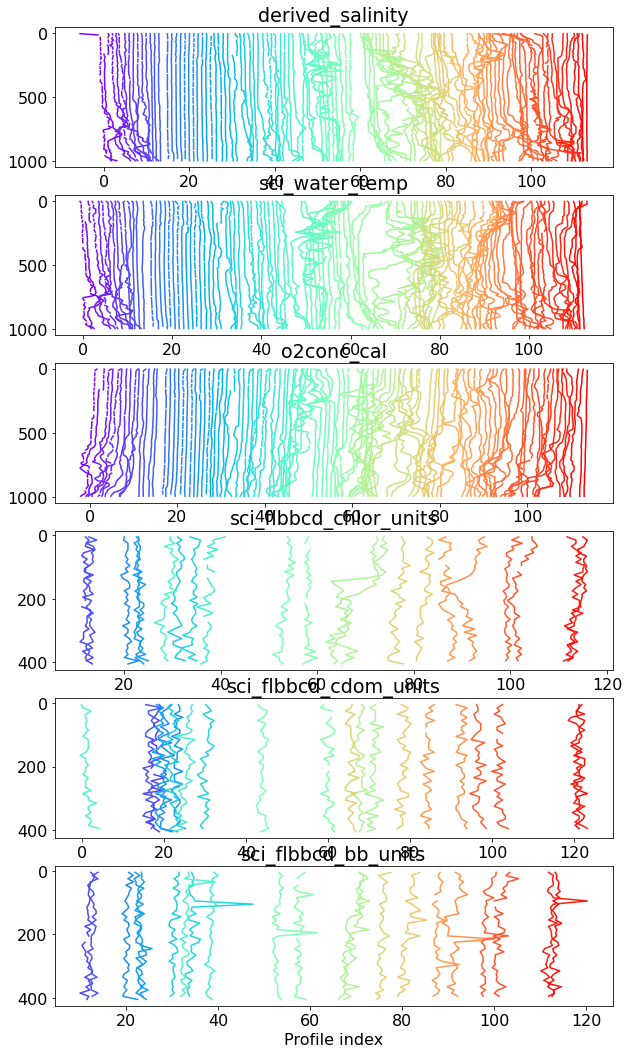

In [15]:
# Would like some waterfall plots, especially of the biological data to see if
# there's anything in there.
import pandas as pd
ndays=10

timename = 'time'
presname = 'pressure'
salname = 'derived_salinity'
tempname = 'sci_water_temp'


varlist = ['derived_salinity', 'sci_water_temp', 'sci_oxy4_oxygen',
          ]

varlist2 = ['derived_salinity', 'sci_water_temp', 'o2conc_cal',
            'sci_flbbcd_chlor_units', 'sci_flbbcd_cdom_units', 
           'sci_flbbcd_bb_units'
            ]

ndays=10

# Get a mean time per profile
time1 = grid409.time.values
timenan = pd.isnull(time1)
time2 = time1.astype('float')
time2[timenan] = np.nan
time3 = np.nanmean(time2,axis=0)
timevec = time3.astype('datetime64[ns]')


grid409["timevec"] = ('divenum', timevec)

# Most recent profiles
max_time = grid409.timevec.max().values
dt1 = np.timedelta64(-ndays, 'D')
ds1 = grid409.where(grid409["timevec"]>=(max_time+dt1), drop=True)


plot_waterfall(ds1, varlist2)

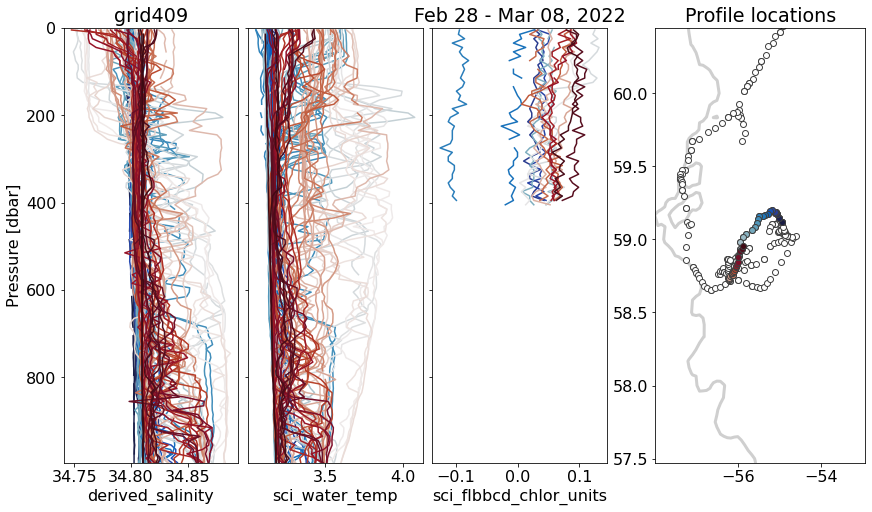

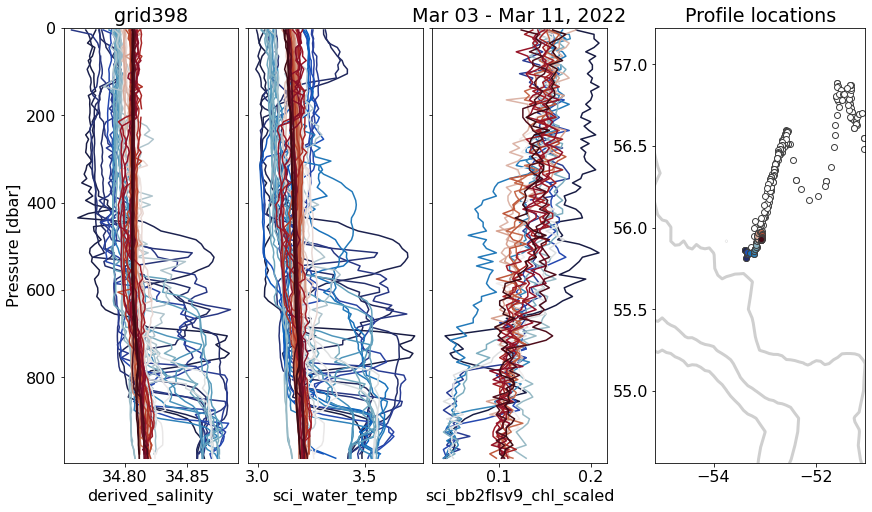

In [16]:
ndays=8
varlist = ['derived_salinity', 'sci_water_temp', 'sci_flbbcd_chlor_units',
          ]

varlist2 = ['derived_salinity', 'sci_water_temp', 'sci_bb2flsv9_chl_scaled']
#grid409
# Makes some simple line plots with color, but needs significant updating
# to have an accurate and appropriate colorbar
plot_gridprof(grid409,ndays,varlist,'grid409', bathylon,bathylat, bathy)
plot_gridprof(grid398,ndays,varlist2,'grid398', bathylon,bathylat, bathy)